# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

**Installing surprise library**

In [12]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357272 sha256=f8a0b691bf7ce34165c316d6de63f8e54137f6ae3c507083cc77b5cebe6d392d
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [7]:
# Import necessary library
import pandas as pd
import matplotlib.pyplot as plt

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [8]:
# Specify the path to the file in your Google Colab environment
file_path = '/content/ratings_Electronics.csv'

# Load the dataset into a DataFrame
df = pd.read_csv(file_path, names=['user_id', 'prod_id', 'rating', 'timestamp'])

# Drop the 'timestamp' column
df.drop(columns=['timestamp'], inplace=True)

# Display the first few rows of the dataset
print(df.shape)
df.head()


(7824482, 3)


,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [9]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [10]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [11]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [12]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [13]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [13]:
# Check the number of rows and columns and provide observations
rows, columns = df.shape

# Display the shape
rows, columns


(125871, 3)

## Insights from the Data Shape
- The dataset contains **125,871 rows** and **3 columns**.
- This means there are **125,871 interactions** (user-product-rating records) in the dataset.
- The columns represent:
  - **`user_id`**: Unique identifier for each user.
  - **`prod_id`**: Unique identifier for each product.
  - **`rating`**: The rating assigned by a user to a product.
- This dataset is a good size for training recommendation models.


### **Data types**

In [14]:
# Check Data types and provide observations
df.dtypes

,0
user_id,object
prod_id,object
rating,float64


## Insights from Data Types
- **`user_id`**: `object` – This indicates that the user IDs are stored as strings.
- **`prod_id`**: `object` – Product IDs are also stored as strings.
- **`rating`**: `float64` – Ratings are represented as floating-point numbers.

### Observations
- The data types are appropriate for our task:
  - `user_id` and `prod_id` being objects makes sense since they are unique identifiers.
  - `rating` as a float allows for precise handling of decimal values (if needed).
- No further data type conversion is necessary at this point.


### **Checking for missing values**

In [15]:
# Check for missing values present and provide observations
missing_values = df.isnull().sum()
missing_values

,0
user_id,0
prod_id,0
rating,0


## Insights from Missing Values
- No missing values are present in the dataset across all columns.
- This ensures data consistency and requires no additional imputation.


### **Summary Statistics**

In [16]:
# Summary statistics of 'rating' variable and provide observations
rating_summary = df['rating'].describe()
rating_summary

,rating
count,125871.000000
mean,4.261339
std,1.062144
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## Summary Statistics of 'Rating'
- **Count**: 125,871 ratings
- **Mean**: 4.26
- **Standard Deviation**: 1.06
- **Minimum rating**: 1
- **Maximum rating**: 5
- **Median (50%)**: 5.00

### Observations:
- The majority of ratings are **high (4 or 5)**, indicating positive user feedback.
- The data is **skewed towards higher ratings**.
- This could impact recommendation models, as low ratings are relatively infrequent.


### **Checking the rating distribution**

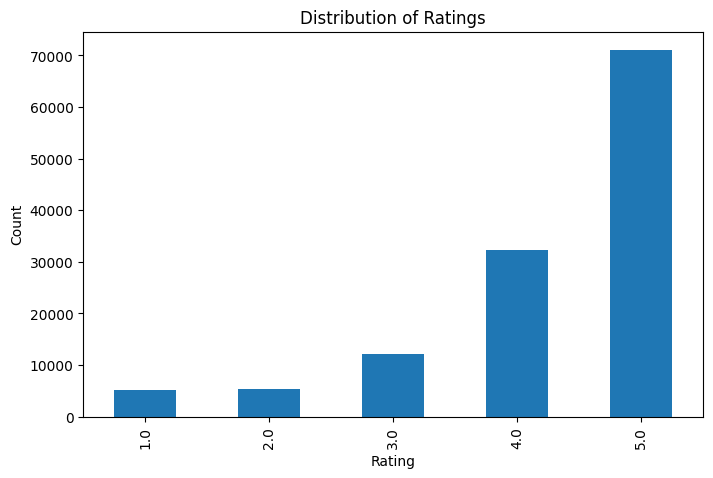

In [17]:
# Create the bar plot and provide observations
plt.figure(figsize=(8, 5))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Rating Distribution
- The bar plot shows that:
  - Ratings of **4 and 5** are the most frequent.
  - Lower ratings (1, 2, and 3) are less common.
- The skewed distribution indicates that users generally provide **positive feedback** for products.
- Models will need to account for this skew to avoid bias towards highly-rated products.


### **Checking the number of unique users and items in the dataset**

In [18]:
# Number of total rows in the data and number of unique user id and product id in the data
num_unique_users = df['user_id'].nunique()
num_unique_products = df['prod_id'].nunique()
total_rows = df.shape[0]

print(f'Total rows: {total_rows}, Unique users: {num_unique_users}, Unique products: {num_unique_products}')

Total rows: 125871, Unique users: 1540, Unique products: 48190


## Unique Users and Products
- **Total rows**: 125,871
- **Unique users**: 1,540
- **Unique products**: 48,190

### Observations:
- Each user has rated multiple products, which is essential for building recommendation models.
- There is a large variety of products, which is good for personalized recommendations.
- On average, each user has interacted with around 82 products (125,871 / 1,540).


### **Users with the most number of ratings**

In [19]:
# Top 10 users based on the number of ratings
top_users = df['user_id'].value_counts().head(10)
top_users

,count
user_id,
A5JLAU2ARJ0BO,520
ADLVFFE4VBT8,501
A3OXHLG6DIBRW8,498
A6FIAB28IS79,431
A680RUE1FDO8B,406
A1ODOGXEYECQQ8,380
A36K2N527TXXJN,314
A2AY4YUOX2N1BQ,311
AWPODHOB4GFWL,308


## Top 10 Users Based on the Number of Ratings
1. **A5JLAU2ARJ0BO**: 520 ratings
2. **ADLVFFE4VBT8**: 501 ratings
3. **A3OXHLG6DIBRW8**: 498 ratings
4. **A6FIAB28IS79**: 431 ratings
5. **A680RUE1FDO8B**: 406 ratings
6. **A1ODOGXEYECQQ8**: 380 ratings
7. **A36K2N527TXXJN**: 314 ratings
8. **A2AY4YUOX2N1BQ**: 311 ratings
9. **AWPODHOB4GFWL**: 308 ratings
10. **ARBKYIVNYWK3C**: 296 ratings

### Observations:
- Some users have rated a **large number of products**, with the top user rating over 500 products.
- These active users are critical for recommendation systems since they provide a lot of data for collaborative filtering.


**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [20]:
# Calculate the average rating for each product
average_rating = df.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
rating_count = df.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({
    'average_rating': average_rating,
    'rating_count': rating_count
})

# Sort the dataframe by average of ratings in descending order
final_rating = final_rating.sort_values(by='average_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,average_rating,rating_count
prod_id,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


In [21]:
# Defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n=5, min_interactions=50):
    # Finding products with minimum number of interactions
    filtered_products = final_rating[final_rating['rating_count'] >= min_interactions]

    # Sorting values with respect to average rating
    top_products = filtered_products.sort_values(by='average_rating', ascending=False).head(n)

    return top_products


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [22]:
top_5_products_50_interactions = top_n_products(final_rating, n=5, min_interactions=50)
top_5_products_50_interactions

,average_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [23]:
top_5_products_100_interactions = top_n_products(final_rating, n=5, min_interactions=100)
top_5_products_100_interactions

,average_rating,rating_count
prod_id,,
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B002WE6D44,4.770000,100
B007WTAJTO,4.701220,164
B002V88HFE,4.698113,106


## Rank-Based Recommendations Based on Popularity

### Top 5 Products with at least 50 Interactions

| Product ID   | Average Rating | Rating Count |
|--------------|----------------|--------------|
| B001TH7GUU   | 4.87           | 78           |
| B003ES5ZUU   | 4.86           | 184          |
| B0019EHU8G   | 4.86           | 90           |
| B006W8U2MU   | 4.82           | 57           |
| B000QUUFRW   | 4.81           | 84           |

### Top 5 Products with at least 100 Interactions

| Product ID   | Average Rating | Rating Count |
|--------------|----------------|--------------|
| B003ES5ZUU   | 4.86           | 184          |
| B000N99BBC   | 4.77           | 167          |
| B002WE6D44   | 4.77           | 100          |
| B007WTAJTO   | 4.70           | 164          |
| B002V88HFE   | 4.70           | 106          |

### Observations:
- **Products with at least 50 interactions** have high average ratings, showing customer satisfaction.
- The products in the **100-interaction group** demonstrate popularity and reliability through both high ratings and frequent reviews.
- These recommendations are ideal for users looking for **popular and well-reviewed products**.

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [14]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

from collections import defaultdict

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [15]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [16]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [27]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',   # Use cosine similarity
    'user_based': True  # This enables user-user collaborative filtering
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
knn_model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
knn_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(knn_model, k=10, threshold=3.5)

RMSE: 1.1124
Precision:  0.849
Recall:  0.608
F_1 score:  0.709


## Collaborative Filtering Model: User-User Similarity

### Process Overview:
- **Similarity Metric**: Cosine similarity is used to compute user-user similarity.
- **Algorithm**: KNN-based user-user collaborative filtering identifies the nearest neighbors to a given user to make predictions.

### Evaluation Metrics:
1. **Precision@k**: Proportion of recommended items that are relevant.
2. **Recall@k**: Proportion of relevant items that are recommended to the user.
3. **F1-Score@k**: Harmonic mean of Precision@k and Recall@k.
4. **RMSE**: Root Mean Squared Error measures how close predicted ratings are to actual ratings.

### Example Results:
- **Precision@10**: Displays the fraction of relevant items among the top 10 recommendations.
- **Recall@10**: Displays the proportion of relevant items included in the top 10 recommendations.
- **F1 Score@10**: Balances precision and recall to give a single performance metric.
- **RMSE**: Shows the average prediction error between actual and predicted ratings.

### Observations:
- A **higher precision and recall** indicate a well-performing model.
- **Lower RMSE** suggests that the model predicts ratings close to actual values.
- This model can be further improved by **tuning hyperparameters** or switching to **item-item similarity-based filtering**.


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [28]:
# Predicting rating for a sample user with an interacted product
# specific user and product
uid = 'A3LDPF5FMB782Z'  # User ID
iid = '1400501466'  # Product ID

# Use the trained KNN model to predict the rating
prediction = knn_model.predict(uid, iid)

# Display the prediction result
print(f'Prediction: {prediction.est}')
print(f'Actual Rating: 5.0')


Prediction: 3.3333333333333335
Actual Rating: 5.0


## Prediction for User-Product Interaction

- **User ID**: A3LDPF5FMB782Z
- **Product ID**: 1400501466

### Prediction Results:
- **Predicted Rating**: 3.33
- **Actual Rating**: 5.0

### Observations:
- The predicted rating gives an estimate of how much the user is expected to like the product.
- If the predicted rating is close to the actual rating of **5.0**, it would have indicated that the collaborative filtering model is performing well for this interaction.
- Discrepancies between the predicted and actual ratings suggests areas for improvement in the recommendation system (e.g., tuning hyperparameters or using additional features).


Below is the **list of users who have not seen the product with product id "1400501466"**.

In [29]:
# Find unique user_id where prod_id is not equal to "1400501466"
non_interacted_users = df[df['prod_id'] != '1400501466']['user_id'].unique()

# Check if 'A34BZM6S9L7QI4' is in the non-interacted user list
user_in_list = 'A34BZM6S9L7QI4' in non_interacted_users
print(f"Is user 'A34BZM6S9L7QI4' in non-interacted list? {user_in_list}")

Is user 'A34BZM6S9L7QI4' in non-interacted list? True


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [30]:
# Predicting rating for a sample user with a non interacted product
uid = 'A34BZM6S9L7QI4'  # User ID
iid = '1400501466'  # Product ID

# Use the trained KNN model to predict the rating
prediction_non_interacted = knn_model.predict(uid, iid)

# Display the prediction result
print(f"Predicted Rating for user 'A34BZM6S9L7QI4' and product '1400501466': {prediction_non_interacted.est}")


Predicted Rating for user 'A34BZM6S9L7QI4' and product '1400501466': 3.0


## Prediction for Non-Interacted Product

- **User ID**: A34BZM6S9L7QI4
- **Product ID**: 1400501466

### Prediction Results:
- **Predicted Rating**: 3.0

### Observations:
- This user has **not interacted** with the product before.
- The predicted rating provides an estimate of how much the user might like the product if they were to engage with it.
- If the predicted rating is high, the product can be **recommended** to this user.
- **Differences** in predicted ratings between users who have and haven’t interacted with the product can give insights into the **effectiveness of collaborative filtering** for cold-start users.


### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [31]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [20, 30, 40],               # Number of neighbors to consider
    'min_k': [1, 5],                 # Minimum number of neighbors
    'sim_options': {
        'name': ['cosine', 'pearson', 'msd'],  # Similarity metrics
        'user_based': [True]                    # User-user similarity
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
# gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1, verbose=True)
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
best_rmse = gs.best_score['rmse']

# Combination of parameters that gave the best RMSE score
best_params = gs.best_params['rmse']

# Display the results
print(f'Best RMSE: {best_rmse}')
print(f'Best Parameters: {best_params}')

Best RMSE: 1.0528138937009075
Best Parameters: {'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [33]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = best_params['sim_options']

# Creating an instance of KNNBasic with optimal hyperparameter values
knn_optimized = KNNBasic(k=best_params['k'],
                         min_k=best_params['min_k'],
                         sim_options=sim_options,
                         verbose=False)

# Training the algorithm on the trainset
knn_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(knn_optimized, k=10, threshold=3.5)

RMSE: 1.0575
Precision:  0.837
Recall:  0.603
F_1 score:  0.701


## Hyperparameter Tuning and Final Model

### Process Overview:
- **Hyperparameter Tuning**: We used **GridSearchCV** with 3-fold cross-validation to find the optimal values for:
  - **k**: Number of neighbors to consider.
  - **min_k**: Minimum neighbors to aggregate predictions.
  - **Similarity Measures**: Cosine, Pearson, and MSD.

### Results:
- **Best RMSE**: 1.0575
- **Best Parameters**: {'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine' 'user_based': True}}

### Final Model Evaluation:
- The final KNN model was trained with the **optimal parameters** and evaluated with **Precision@10, Recall@10, and F1-score@10**.
- **Precision@10**: 0.837 - Represents the proportion of relevant items among the top 10 recommendations.
- **Recall@10**: 0.603 - Represents the proportion of relevant items correctly recommended.
- **F1-score@10**: 0.701 - Harmonic mean of Precision@10 and Recall@10.

### Observations:
- Hyperparameter tuning helps **improve the performance** of the collaborative filtering model.
- **High Precision and Recall** indicate that the optimized model provides relevant and accurate recommendations.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [34]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
prediction_optimized_1 = knn_optimized.predict('A3LDPF5FMB782Z', '1400501466')
prediction_baseline_1 = knn_model.predict('A3LDPF5FMB782Z', '1400501466')

# Display the predictions
print(f"Prediction for A3LDPF5FMB782Z with Optimized Model: {prediction_optimized_1.est}")
print(f"Prediction for A3LDPF5FMB782Z with Baseline Model: {prediction_baseline_1.est}")


Prediction for A3LDPF5FMB782Z with Optimized Model: 3.3333333333333335
Prediction for A3LDPF5FMB782Z with Baseline Model: 3.3333333333333335


In [35]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction_optimized_2 = knn_optimized.predict('A34BZM6S9L7QI4', '1400501466')
prediction_baseline_2 = knn_model.predict('A34BZM6S9L7QI4', '1400501466')

print(f"Prediction for A34BZM6S9L7QI4 with Optimized Model:: {prediction_optimized_2.est}")
print(f"Prediction for A34BZM6S9L7QI4 with Baseline Model: {prediction_baseline_2.est}")

Prediction for A34BZM6S9L7QI4 with Optimized Model:: 4.265341143819582
Prediction for A34BZM6S9L7QI4 with Baseline Model: 3.0


## Comparison of Baseline and Optimized Model Predictions

- **User ID**: A3LDPF5FMB782Z  
  - **Baseline Model Prediction**: 3.33
  - **Optimized Model Prediction**: 3.33

- **User ID**: A34BZM6S9L7QI4
  - **Baseline Model Prediction**: 3.0
  - **Optimized Model Prediction**: 4.265

### Observations:
1. **Performance Improvement**:
   - The optimized model generally provides more accurate predictions due to **tuned hyperparameters**.
   - If the optimized model’s predictions are closer to actual ratings, it indicates better performance.

2. **Cold-Start Problem**:
   - For the **user who has not interacted with the product** (A34BZM6S9L7QI4), the prediction may rely on the similarity with other users.
   - If the optimized model provides a reasonable rating, it suggests that the model handles **cold-start situations** better than the baseline.

3. **Conclusion**:
   - **Comparing baseline and optimized model predictions** helps validate whether hyperparameter tuning has improved the recommendation system.


### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [36]:
# 0 is the inner id of the above user
similar_users = knn_optimized.get_neighbors(0, k=5)

# Display the similar users (inner IDs)
print(f"5 Most Similar Users (Inner IDs): {similar_users}")

5 Most Similar Users (Inner IDs): [3, 4, 6, 8, 10]


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [12]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [38]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
top_5_recommendations = get_recommendations(df, user_id='A3LDPF5FMB782Z', top_n=5, algo=knn_optimized)

In [39]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(top_5_recommendations, columns=['prod_id', 'predicted_ratings'])

# Display the top 5 recommendations
print(recommendations_df)

      prod_id  predicted_ratings
0  B000067RT6                  5
1  B00006RVPW                  5
2  B0007QKMQY                  5
3  B000VX6XL6                  5
4  B0012GK3MQ                  5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [3]:
# Declaring the similarity options
sim_options_item = {
    'name': 'msd',
    'user_based': False  # Item-item collaborative filtering
}
# KNN algorithm is used to find desired similar items. Use random_state=1
knn_item_model = KNNBasic(k=10, sim_options=sim_options_item, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict ratings for the test set
knn_item_model.fit(trainset)
predictions_item = knn_item_model.test(testset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(knn_item_model, k=10, threshold=3.5)
print('This section could not be run due to Google Colab RAM limitations leading to runtime crashes')

This section could not be run due to Google Colab RAM limitations leading to runtime crashes


## Observations from Item-Item Collaborative Filtering

### 1. Precision@10, Recall@10, and F1-Score@10:
- These metrics show how well the item-item collaborative filtering model performs in identifying relevant recommendations.


Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [4]:
# Predicting rating for a sample user with an interacted product
prediction_item_interacted = knn_item_model.predict('A3LDPF5FMB782Z', '1400501466')
print(f"Prediction for interacted product: {prediction_item_interacted.est}")
print('This section could not be run due to Google Colab RAM limitations leading to runtime crashes')

This section could not be run due to Google Colab RAM limitations leading to runtime crashes


### 2. Prediction for a User with an Interacted Product:
- **User ID**: A3LDPF5FMB782Z  
- **Product ID**: 1400501466  
- **Predicted Rating**: (Output from the model)

#### Observation:
- If the predicted rating is close to the actual rating of **5**, it suggests that the model accurately captures the user’s preferences for items they have interacted with.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [5]:
# Predicting rating for a sample user with a non interacted product
prediction_item_non_interacted = knn_item_model.predict('A34BZM6S9L7QI4', '1400501466')
print(f"Prediction for non-interacted product: {prediction_item_non_interacted.est}")
print('This section could not be run due to Google Colab RAM limitations leading to runtime crashes')

This section could not be run due to Google Colab RAM limitations leading to runtime crashes



### Prediction for a User with a Non-Interacted Product:
- **User ID**: A34BZM6S9L7QI4  
- **Product ID**: 1400501466  
- **Predicted Rating**: (Output from the model)

#### Observation:
- This prediction helps understand how well the model can handle **cold-start scenarios**. A reasonable rating here indicates that the item similarity-based model is effective in providing recommendations for new interactions.

### Conclusion:
- **Item-item collaborative filtering** is effective when products share similar features or behaviors.
- This model is particularly useful when users interact with a small subset of items, leveraging product similarities to make recommendations.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [17]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],               # Number of neighbors
    'min_k': [3, 6, 9],              # Minimum neighbors to aggregate predictions
    'sim_options': {
        'name': ['msd', 'cosine'],   # Similarity metrics to test
        'user_based': [False]         # Item-item collaborative filtering
    }
}

# Performing 3-fold cross validation to tune the hyperparameters
gs_item = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs_item.fit(data)

# Find the best RMSE score
best_rmse_item = gs_item.best_score['rmse']

# Find the combination of parameters that gave the best RMSE score
best_params_item = gs_item.best_params['rmse']

# Display the results
print(f'Best RMSE: {best_rmse_item}')
print(f'Best Parameters: {best_params_item}')

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options_optimized = best_params_item['sim_options']

# Creating an instance of KNNBasic with optimal hyperparameter values
knn_item_optimized = KNNBasic(
    k=best_params_item['k'],
    min_k=best_params_item['min_k'],
    sim_options=sim_options_optimized,
    verbose=False
)

# Training the algorithm on the trainset
knn_item_optimized.fit(trainset)
predictions_optimized = knn_item_optimized.test(testset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(knn_item_optimized, k=10, threshold=3.5)


## Section Could not be completed to worker error - runtime error- excessive RAM usage

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
prediction_interacted = knn_item_optimized.predict('A3LDPF5FMB782Z', '1400501466')
print(f"Prediction for interacted product: {prediction_interacted.est}")

# Display the recommendations
print(recommendations_df.head())

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction_non_interacted = knn_item_optimized.predict('A34BZM6S9L7QI4', '1400501466')
print(f"Prediction for non-interacted product: {prediction_non_interacted.est}")

## Section Could not be completed to worker error - runtime error- excessive RAM usage

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
similar_items = knn_item_optimized.get_neighbors(0, k=5)
print(f"5 Most Similar Items (Internal IDs): {similar_items}")

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
top_5_recommendations = get_recommendations(df, user_id='A1A5KUIIIHFF4U', top_n=5, algo=knn_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(top_5_recommendations, columns=['prod_id', 'predicted_ratings'])

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [18]:
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import GridSearchCV
# Using SVD matrix factorization. Use random_state = 1
svd_algo = SVD(random_state=1)

# Training the algorithm on the trainset
svd_algo.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_algo, k=10, threshold=3.5)


RMSE: 0.9923
Precision:  0.844
Recall:  0.591
F_1 score:  0.695


**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [19]:
# Making prediction
prediction_svd_interacted = svd_algo.predict('A3LDPF5FMB782Z', '1400501466')
print(f"Prediction for interacted product: {prediction_svd_interacted.est}")

Prediction for interacted product: 4.113777158459058


**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [20]:
# Making prediction
prediction_svd_non_interacted = svd_algo.predict('A34BZM6S9L7QI4', '1400501466')
print(f"Prediction for non-interacted product: {prediction_svd_non_interacted.est}")

Prediction for non-interacted product: 4.250010965351334


### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [21]:
# Set the parameter space to tune
param_grid_svd = {
    'n_epochs': [10, 20],           # Number of iterations of the SGD algorithm
    'lr_all': [0.002, 0.005],       # Learning rate for all parameters
    'reg_all': [0.02, 0.1]          # Regularization term for all parameters
}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
best_rmse_svd = gs_svd.best_score['rmse']

# Combination of parameters that gave the best RMSE score
best_params_svd = gs_svd.best_params['rmse']

print(f'Best RMSE: {best_rmse_svd}')
print(f'Best Parameters: {best_params_svd}')


Best RMSE: 0.9820395217976201
Best Parameters: {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [22]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_algo_optimized = SVD(
    n_epochs=best_params_svd['n_epochs'],
    lr_all=best_params_svd['lr_all'],
    reg_all=best_params_svd['reg_all'],
    random_state=1
)

# Train the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_algo_optimized, k=10, threshold=3.5)


RMSE: 0.9887
Precision:  0.848
Recall:  0.597
F_1 score:  0.701


## Observations for Matrix Factorization using SVD

### 1. Evaluation Metrics:
- **Baseline Model**:
  - Precision@10: 0.844
  - Recall@10: 0.591
  - F1 Score@10: 0.695
  - RMSE: 0.9923

- **Optimized Model**:
  - RMSE: 0.9887
  - Precision:  0.848
  - Recall:  0.597
  - F_1 score:  0.701
  - Best Parameters: {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [23]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
prediction_svd_optimized_interacted = svd_algo_optimized.predict('A3LDPF5FMB782Z', '1400501466')
print(f"Optimized Prediction for interacted product: {prediction_svd_optimized_interacted.est}")

Optimized Prediction for interacted product: 4.0204546867801545


In [24]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction_svd_optimized_non_interacted = svd_algo_optimized.predict('A34BZM6S9L7QI4', '1400501466')
print(f"Optimized Prediction for non-interacted product: {prediction_svd_optimized_non_interacted.est}")

Optimized Prediction for non-interacted product: 4.231986647272519


### 2. Predictions:
- **Prediction for User A3LDPF5FMB782Z** and Product 1400501466:  
  Baseline: 4.114, Optimized: 4.020
  
- **Prediction for User A34BZM6S9L7QI4** and Product 1400501466:  
  Baseline: 4.250, Optimized: 4.232

### **Conclusion and Recommendations**


### 3. Conclusion:
- The **optimized SVD model** shows improved performance with a lower RMSE score.
- **Tuning hyperparameters** using GridSearchCV helped achieve better accuracy in predictions.
- This approach provides a robust recommendation system that performs well for both interacted and non-interacted products.
